In [71]:
import numpy as np
import pandas as pd
import cartopy.crs as ccrs

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pdf

In [72]:
# Watermark is not required for this code, but is included for information. 
import watermark
%load_ext watermark
%watermark -a "ELEANOR LUTZ" -d -v -iv -m

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Author: ELEANOR LUTZ

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

Compiler    : MSC v.1938 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : AMD64 Family 25 Model 80 Stepping 0, AuthenticAMD
CPU cores   : 16
Architecture: 64bit

pandas    : 2.2.2
watermark : 2.4.3
numpy     : 1.26.4
matplotlib: 3.8.4
cartopy   : 0.23.0



In [73]:
# Find the Segoe font that can plot symbols used in map
# Code from the tutorial at this link:
# https://jdhao.github.io/2018/04/08/matplotlib-unicode-character/

from fontTools.ttLib import TTFont
import matplotlib.font_manager as mfm

def char_in_font(Unicode_char, font):
    for cmap in font['cmap'].tables:
        if cmap.isUnicode():
            if ord(Unicode_char) in cmap.cmap:
                return True
    return False

uni_chars = [u"\u16b8", u"\u16e5", u"\u16BC", u"\u16bb", 
             u"\u2724", u"\u25c8", u"\u2388", u"\u214f"]

font_info = [(f.fname, f.name) for f in mfm.fontManager.ttflist]

for uni_char in uni_chars:
    for i, font in enumerate(font_info):
        if char_in_font(uni_char, TTFont(font[0], fontNumber=0)):
            if font[1].split()[0] == "Segoe":
                print(uni_char, ":", font[0], font[1])
                break
                
seguihis = 'C:\WINDOWS\Fonts\seguihis.ttf'
prop_seguihis = mfm.FontProperties(fname=seguihis)

seguisym = 'C:\WINDOWS\Fonts\seguisym.ttf'
prop_seguisym = mfm.FontProperties(fname=seguisym)

<>:27: SyntaxWarning: invalid escape sequence '\W'
<>:30: SyntaxWarning: invalid escape sequence '\W'
<>:27: SyntaxWarning: invalid escape sequence '\W'
<>:30: SyntaxWarning: invalid escape sequence '\W'
C:\Users\marti\AppData\Local\Temp\ipykernel_8724\145642472.py:27: SyntaxWarning: invalid escape sequence '\W'
  seguihis = 'C:\WINDOWS\Fonts\seguihis.ttf'
C:\Users\marti\AppData\Local\Temp\ipykernel_8724\145642472.py:30: SyntaxWarning: invalid escape sequence '\W'
  seguisym = 'C:\WINDOWS\Fonts\seguisym.ttf'


ᚸ : C:\Windows\Fonts\seguihis.ttf Segoe UI Historic
ᛥ : C:\Windows\Fonts\seguihis.ttf Segoe UI Historic
ᚼ : C:\Windows\Fonts\seguihis.ttf Segoe UI Historic
ᚻ : C:\Windows\Fonts\seguihis.ttf Segoe UI Historic
✤ : C:\Windows\Fonts\seguisym.ttf Segoe UI Symbol
◈ : C:\Windows\Fonts\seguisym.ttf Segoe UI Symbol
⎈ : C:\Windows\Fonts\seguisym.ttf Segoe UI Symbol
⅏ : C:\Windows\Fonts\seguisym.ttf Segoe UI Symbol


In [74]:
def set_save_image(fig, savename, dpi=1200):
    # Output text as editable PDF text objects instead of shapes
    matplotlib.rcParams['pdf.fonttype'] = 42
    
    # Force PDF to respect zorder by supressing image compositing
    matplotlib.rcParams['image.composite_image'] = False

    # Remove borders on the plot axes
    for ax in fig.get_axes():
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.axis('off')
        try:
            ax.set_global()
            ax.outline_patch.set_edgecolor('none')
            ax.background_patch.set_fill(False)
        except:
            pass 
        
    # Remove all padding and margins
    plt.tight_layout()
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(matplotlib.pyplot.NullLocator())
    plt.gca().yaxis.set_major_locator(matplotlib.pyplot.NullLocator())
        
    if savename.split('.')[-1] == 'pdf':
        pp = pdf.PdfPages(savename, keep_empty=False)
        pp.savefig(fig)
        pp.close()
    elif savename.split('.')[-1] == 'png':
        plt.savefig(savename, format='png', dpi=dpi, pad_inches=0, transparent=True)
    else:
        print("Unrecognized file format, plot not saved!")

    plt.show()
    plt.clf()
    plt.close('all')

In [75]:
stars = pd.read_csv('./data/processed/hygdata_processed_mag65.csv')
asterisms = pd.read_csv('./data/processed/asterisms.csv')
constellations = pd.read_csv('./data/processed/constellations.csv')
const_names = pd.read_csv('./data/processed/centered_constellations.csv', encoding="latin-1")
messiers = pd.read_csv('./data/processed/messier_ngc_processed.csv')
display(messiers.head())

print(len(stars), 'stars to plot')
print(len(asterisms), 'asterisms to plot')
print(len(constellations), 'constellations to plot')
print(len(const_names), 'constellation names to plot')
print(len(messiers), 'messier objects to plot')
print(len(messiers[pd.notnull(messiers['proper_name'])]), 'named messiers to plot')

figsize = (20, 10)
const_color = '#ff2620'
zodiac_color = '#fcb322'
nonzodiac_color = '#77a9da'
other_color = '#979330'

class LowerThresholdPlateCarree(ccrs.PlateCarree):
    def __init__(self, threshold_value):
        super().__init__()  # Call the parent class constructor
        self._threshold = threshold_value

    @property
    def threshold(self):
        return self._threshold

    @threshold.setter
    def threshold(self, new_threshold):
        self._threshold = 0.01


projection_method = ccrs.AzimuthalEquidistant(0, 90)


,name,type,ra,dec,magnitude,proper_name,ra_original,dec_original,code,name_2
0,M11,open cluster,18.851667,-6.266667,5.8,Wild Duck Cluster,18h 51.1m,-6d 16',ᚸ,Wild Duck Cluster
1,M13,globular cluster,16.695000,36.466667,5.8,Hercules Cluster,16h 41.7m,+36d 28',✤,Hercules Cluster
2,M15,globular cluster,21.500000,12.166667,6.2,NaN,21h 30m,+12d 10',✤,M15
3,M16,open cluster,18.313333,-13.783333,6.0,Eagle Nebula,18h 18.8m,-13d 47',ᚸ,Eagle Nebula
4,M17,"emission nebula, open cluster",18.346667,-16.183333,6.0,Swan Nebula,18h 20.8m,-16d 11',◈,Swan Nebula


8912 stars to plot
88 asterisms to plot
89 constellations to plot
88 constellation names to plot
66 messier objects to plot
16 named messiers to plot


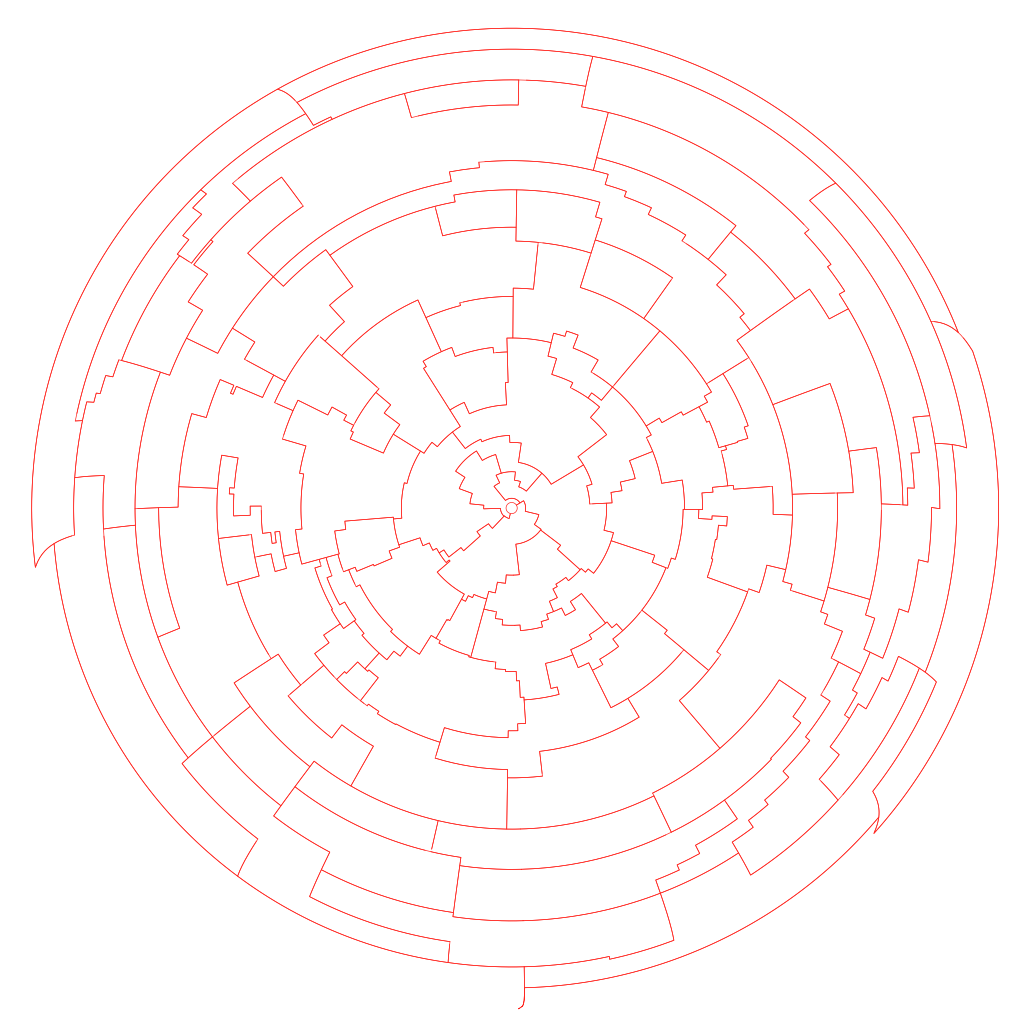

In [76]:
fig = plt.figure(figsize=figsize)
ax = plt.axes(projection=projection_method)

for index, row in constellations.iterrows():
    ras = [float(x)*360/24 for x in row['ra'].replace('[', '').replace(']', '').split(',')]
    decs = [float(x) for x in row['dec'].replace('[', '').replace(']', '').split(',')]
    ax.plot(ras, decs, transform=ccrs.Geodetic(), lw=0.5, alpha=1, color=const_color)
    
ax.set_xlim(ax.get_xlim()[::-1])
set_save_image(fig, './figures/constellations.png')

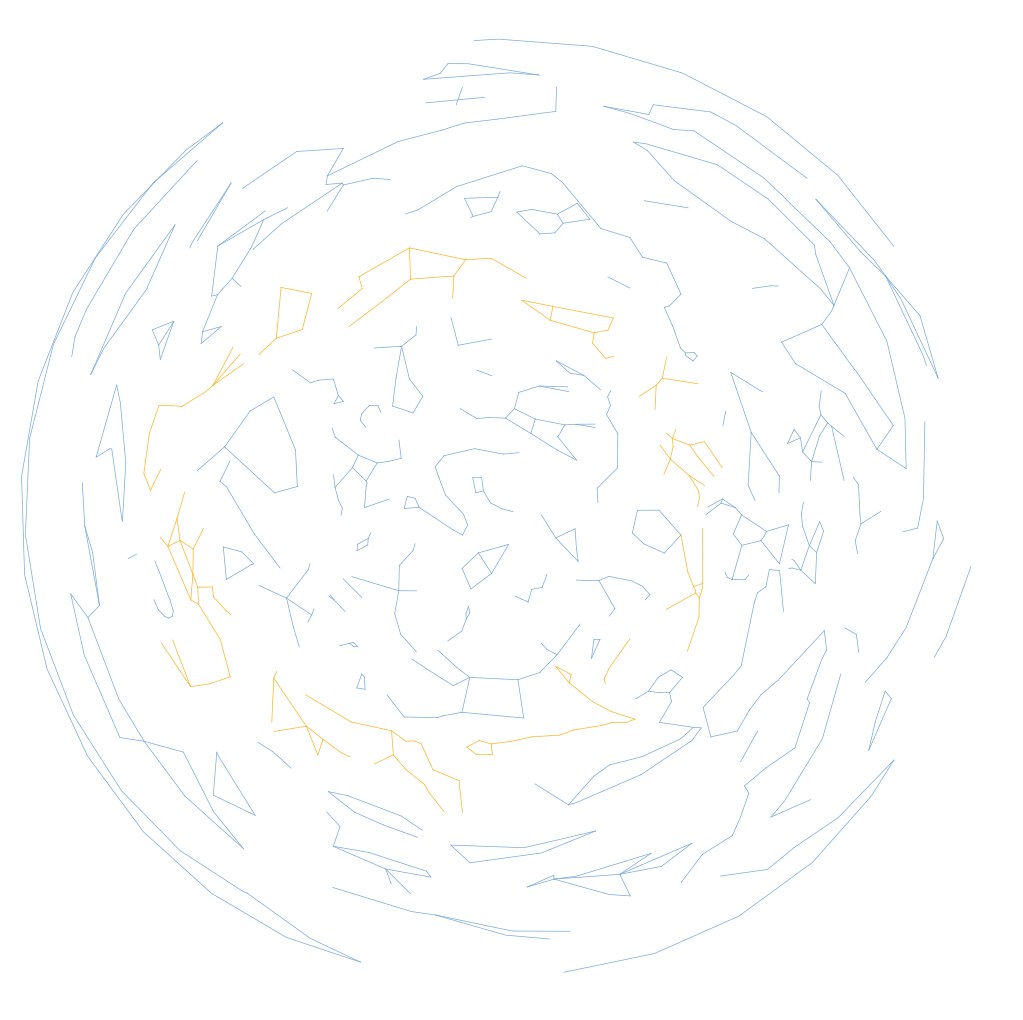

In [77]:
fig = plt.figure(figsize=figsize)
ax = plt.axes(projection=projection_method)

for index, row in asterisms.iterrows():
    ras = [float(x)*360/24 for x in row['ra'].replace('[', '').replace(']', '').split(',')]
    decs = [float(x) for x in row['dec'].replace('[', '').replace(']', '').split(',')]
    color = nonzodiac_color
    if row['zodiac'] == True: 
        color = zodiac_color
    assert len(asterisms)%2 == 0
    for n in range(int(len(asterisms)/2)):
        ax.plot(ras[n*2:(n+1)*2], decs[n*2:(n+1)*2], transform=ccrs.Geodetic(), color=color, lw=0.5)
    
ax.set_xlim(ax.get_xlim()[::-1])
set_save_image(fig, './figures/asterisms.png')

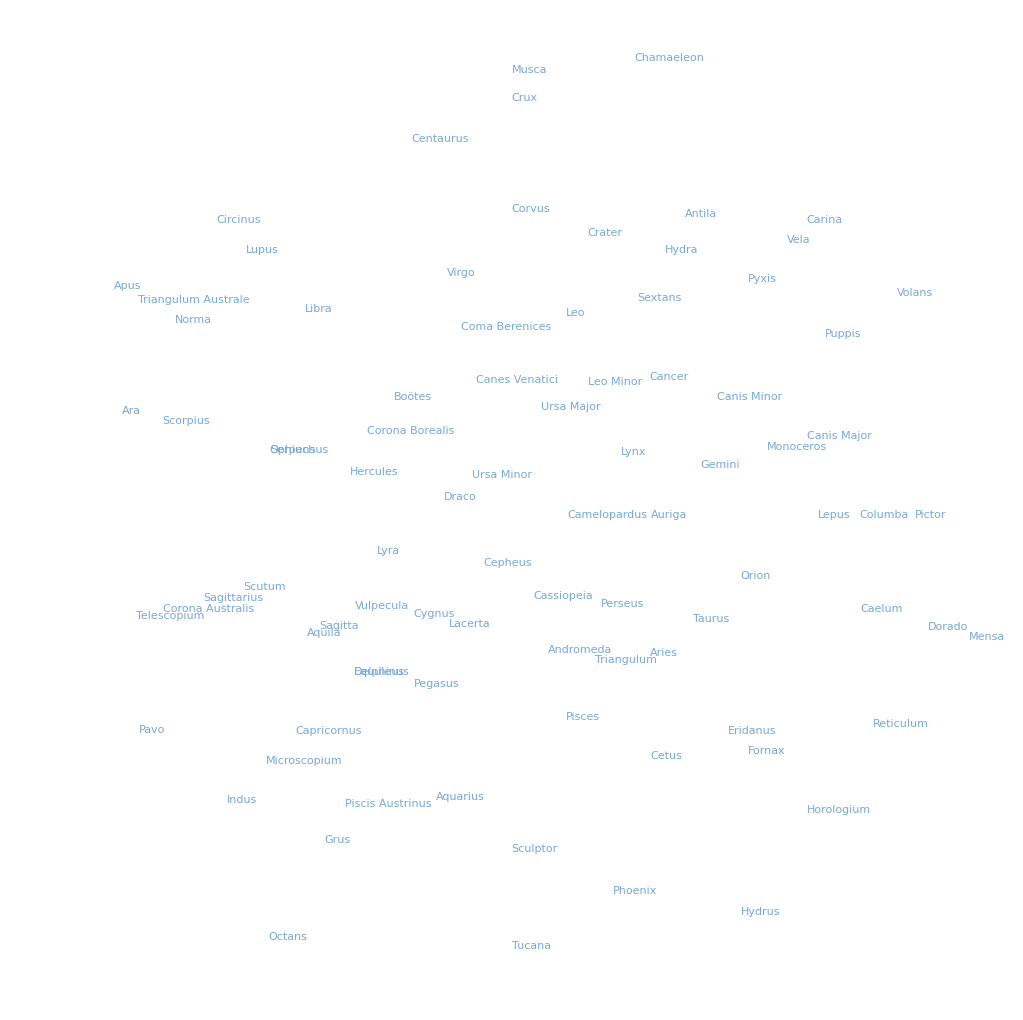

In [78]:
fig = plt.figure(figsize=figsize)
ax = plt.axes(projection=projection_method)

for index, row in const_names.iterrows(): 
    ax.text(row['ra']*360/24, row['dec'], row['name'], 
            transform=ccrs.Geodetic(), ha='left', va='top', fontsize=8, color=nonzodiac_color)
    
ax.set_xlim(ax.get_xlim()[::-1])
set_save_image(fig, './figures/constellation_names.pdf')

1516 labeled stars to plot


MERG NOT subset; don't know how to subset; dropped


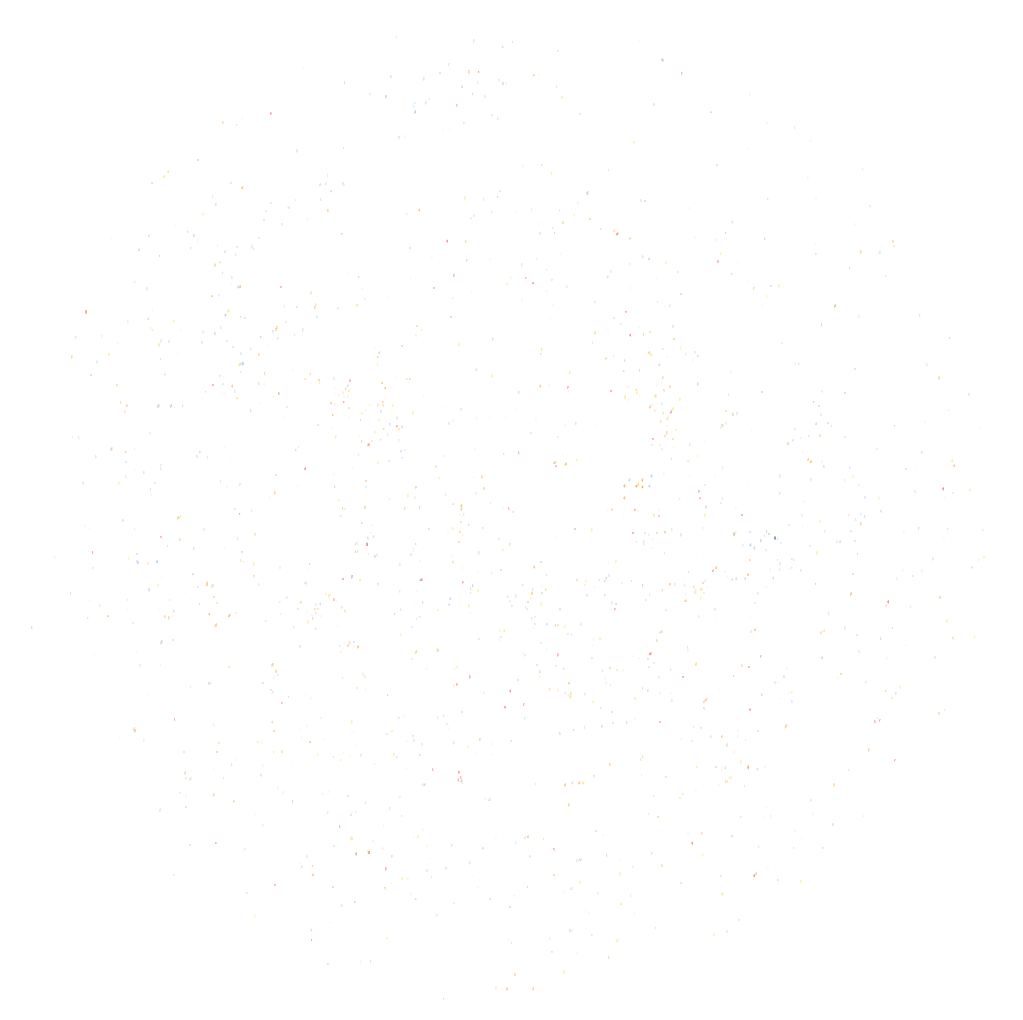

In [79]:
fig = plt.figure(figsize=figsize)
ax = plt.axes(projection=projection_method)

bayers = stars[pd.notnull(stars['bayer'])]
print(len(bayers), 'labeled stars to plot')

for index, row in bayers.iterrows(): 
    ax.text(row['ra']*360/24, row['dec'], row['greek_letters'], transform=ccrs.Geodetic(), 
            ha='center', va='center', fontsize=2, color=row['linecolor'], fontproperties=prop_seguisym)
    
ax.set_xlim(ax.get_xlim()[::-1])
set_save_image(fig, './figures/greek_letters.pdf')

131 labeled stars to plot


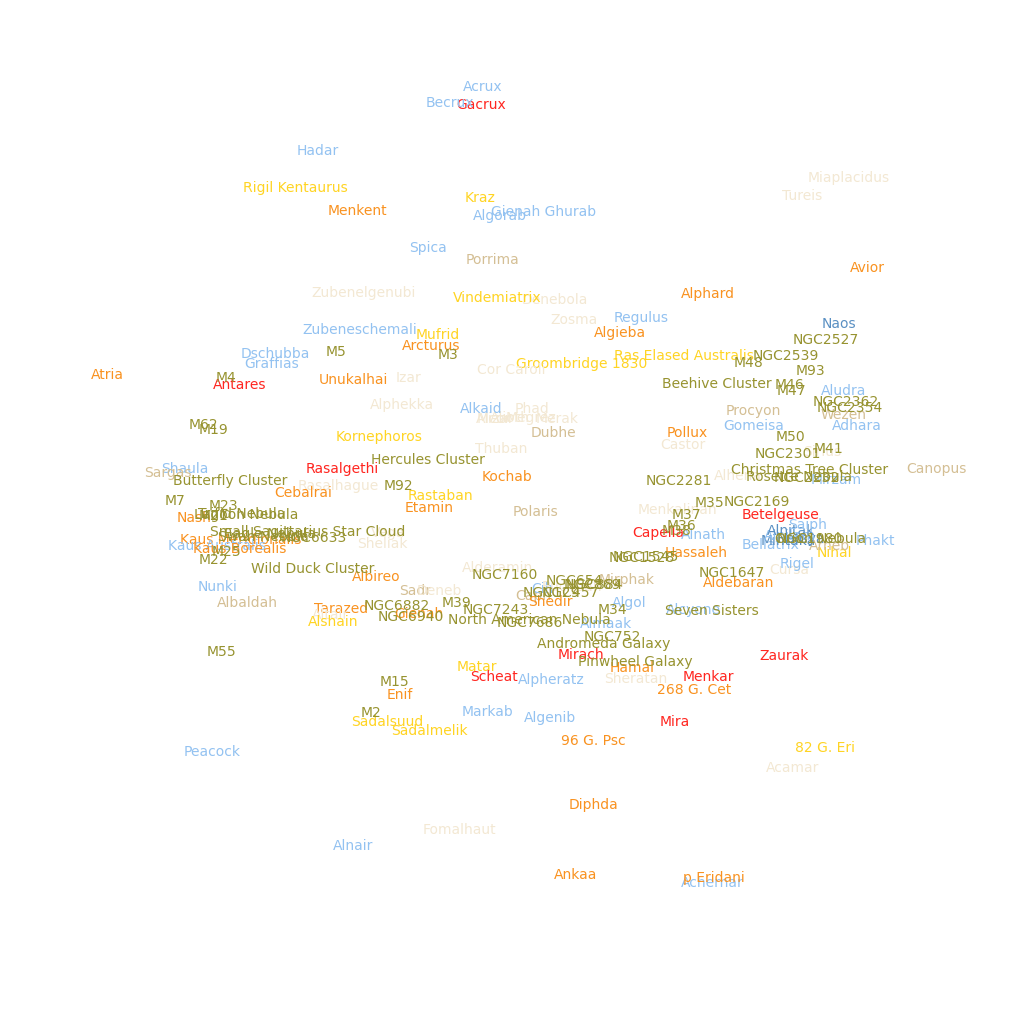

In [80]:
fig = plt.figure(figsize=figsize)
ax = plt.axes(projection=projection_method)

names = stars[pd.notnull(stars['proper'])]
print(len(names), 'labeled stars to plot')

for index, row in names.iterrows(): 
    ax.text(row['ra']*360/24, row['dec'], row['proper'], color=row['linecolor'],
            ha='left', va='center', transform=ccrs.Geodetic())
    
for index, row in messiers.iterrows(): 
    ax.text(row['ra']*360/24, row['dec'], row['name_2'], color=other_color,
            ha='left', va='center', transform=ccrs.Geodetic())
    
ax.set_xlim(ax.get_xlim()[::-1])
set_save_image(fig, './figures/names.pdf')

7717 non-variable stars to plot


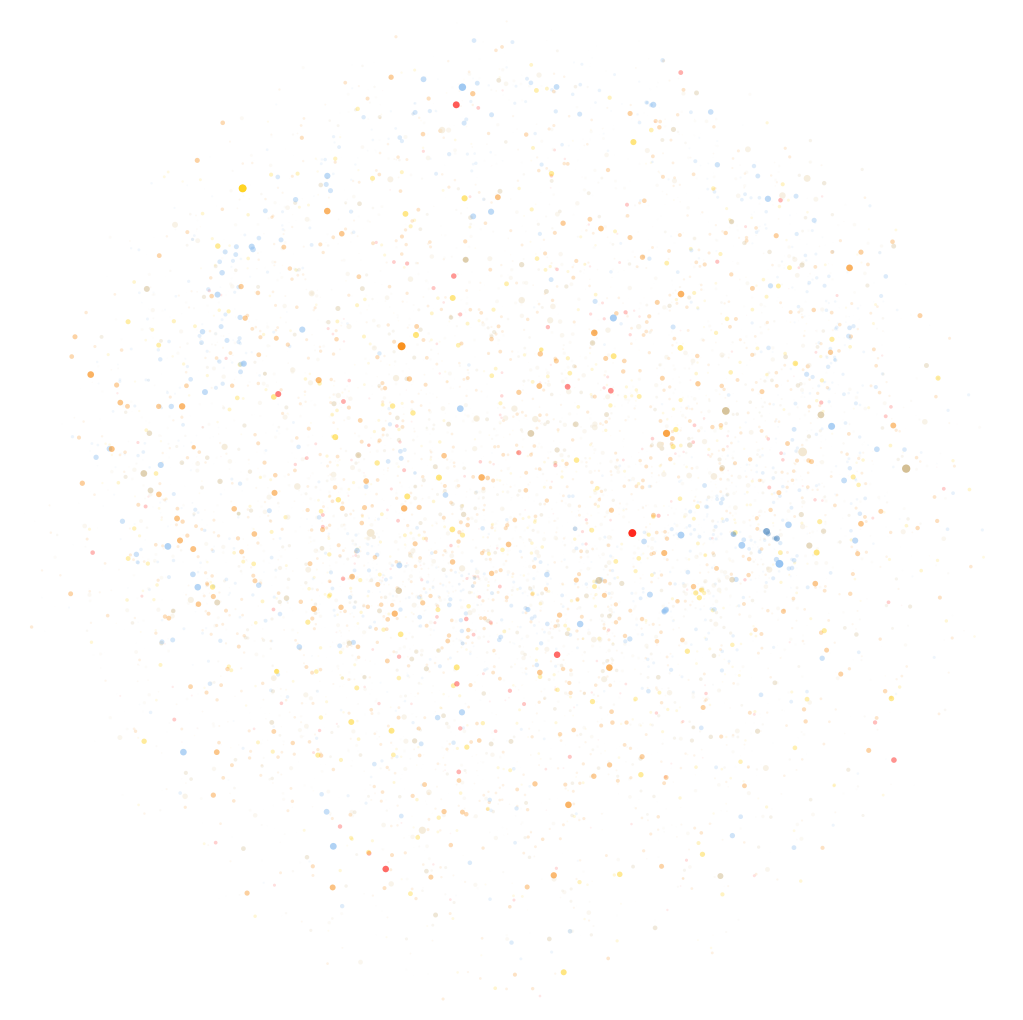

In [81]:
fig = plt.figure(figsize=figsize)
ax = plt.axes(projection=projection_method)

stars_nonvar = stars[pd.isnull(stars['var'])]
stars_nonvar = stars_nonvar[stars_nonvar['color'] != '#000000']
print(len(stars_nonvar), 'non-variable stars to plot')

for index, row in stars_nonvar.iterrows(): 
    try:
        ax.scatter(row['ra']*360/24, row['dec'], transform=ccrs.Geodetic(),
           s=(6.5-row['mag'])*5, color=row['color'], lw=0, edgecolor='none', 
           alpha=min(1, ((6.5-row['mag'])*5)/(6.5*5)), zorder=6.5-row['mag'])
    except:
        print(row['ra'], row['dec'], row['mag'], row['color'])
    
ax.set_xlim(ax.get_xlim()[::-1])
set_save_image(fig, './figures/star_fills.png')

7723 non-variable stars to plot


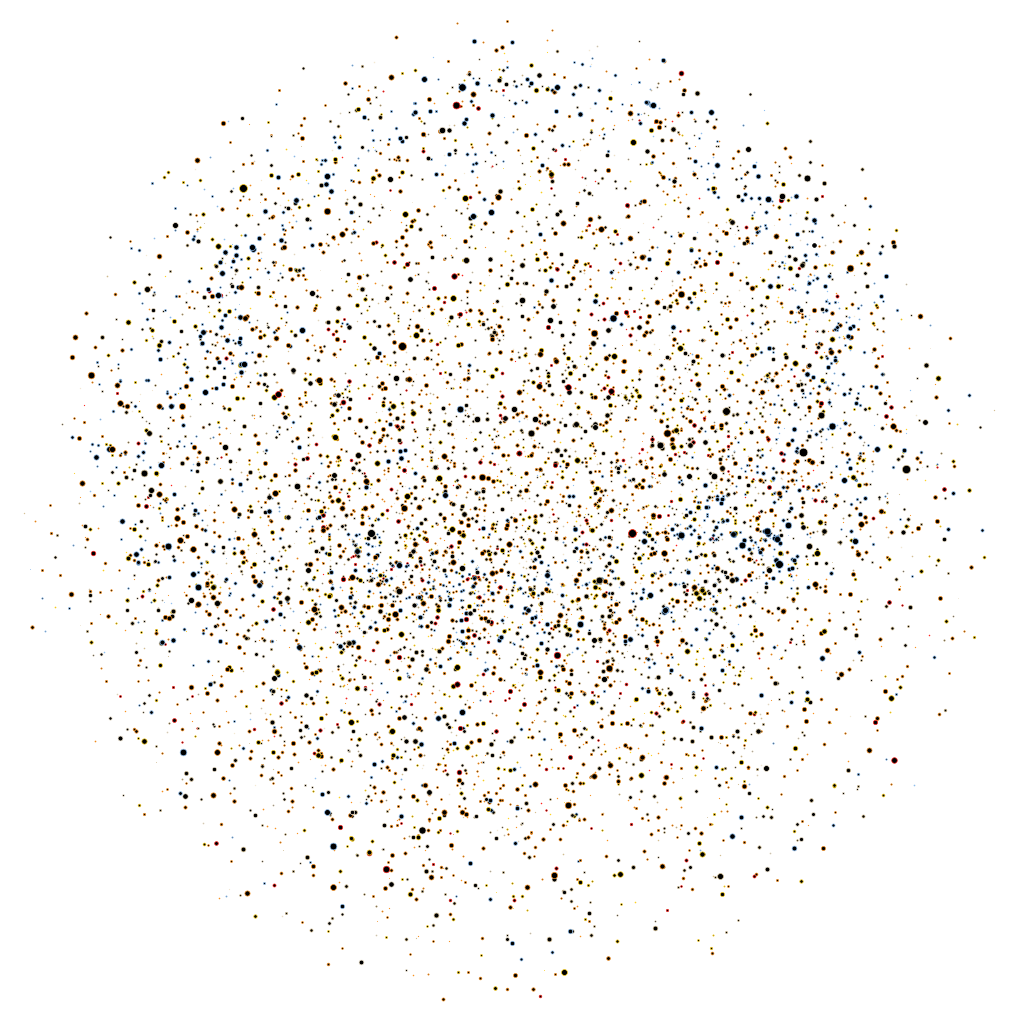

In [82]:
fig = plt.figure(figsize=figsize)
ax = plt.axes(projection=projection_method)

stars_nonvar = stars[pd.isnull(stars['var'])]
print(len(stars_nonvar), 'non-variable stars to plot')

for index, row in stars_nonvar.iterrows(): 
    try:
        ax.scatter(row['ra']*360/24, row['dec'], transform=ccrs.Geodetic(), alpha=1,
           s=(6.5-row['mag'])*5, edgecolor=row['color'], lw=0.5, color='k', zorder=6.5-row['mag'])
    except:
        print(row['ra'], row['dec'], row['mag'], row['color'])
    
ax.set_xlim(ax.get_xlim()[::-1])
set_save_image(fig, './figures/star_lines.png')

1189 variable stars to overplot


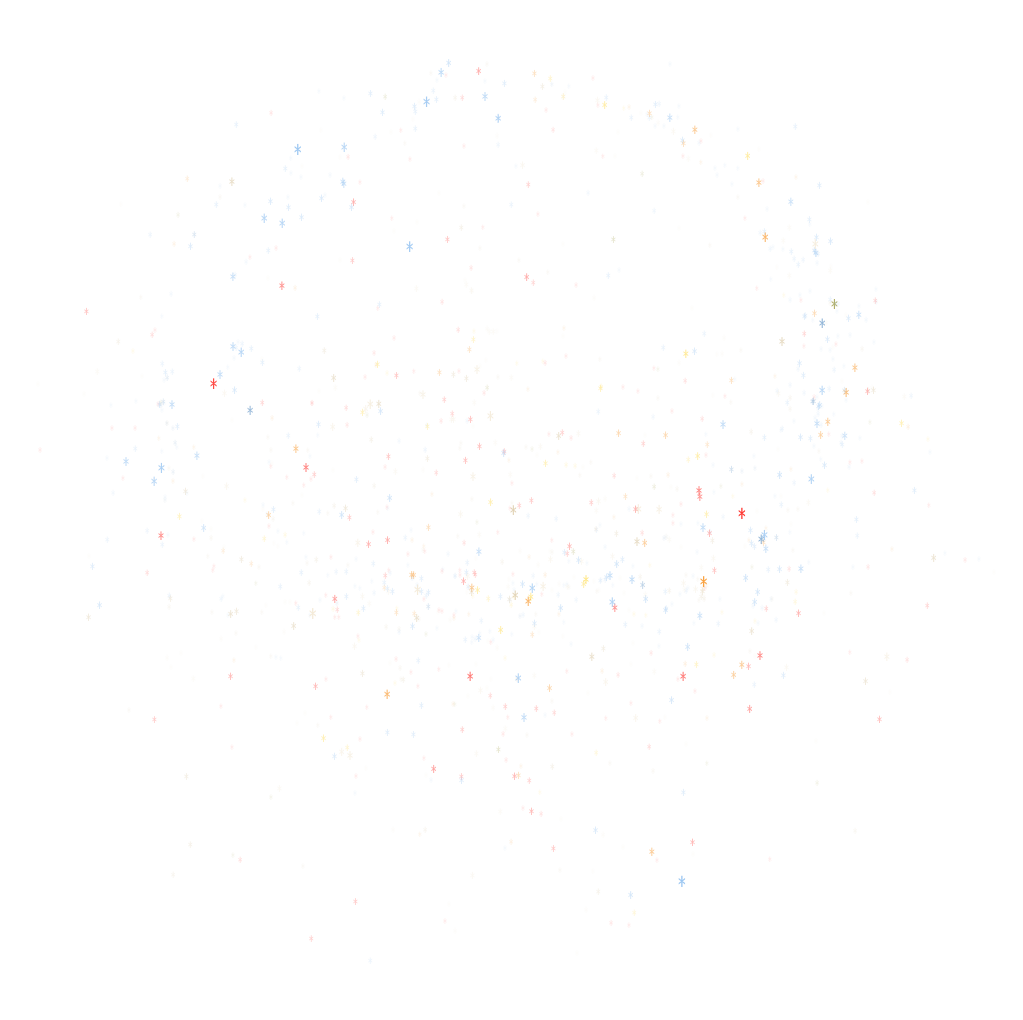

In [83]:
fig = plt.figure(figsize=figsize)
ax = plt.axes(projection=projection_method)
ax.set_global()
# ax.background_patch.set_fill(False)

stars_var = stars[pd.notnull(stars['var'])]
print(len(stars_var), 'variable stars to overplot')

for index, row in stars_var.iterrows(): 
    ax.text(row['ra']*360/24, row['dec'], u"\u16BC", transform=ccrs.Geodetic(),
            fontproperties=prop_seguihis, fontsize=(12-row['mag']), 
            alpha=max(0.1, min(1,((6.5-row['mag'])*5)/(6.5*5))), color=row['color'], ha='center', va='center')
    
ax.set_xlim(ax.get_xlim()[::-1])
ax.axis('off')
set_save_image(fig, './figures/variable_stars.png')

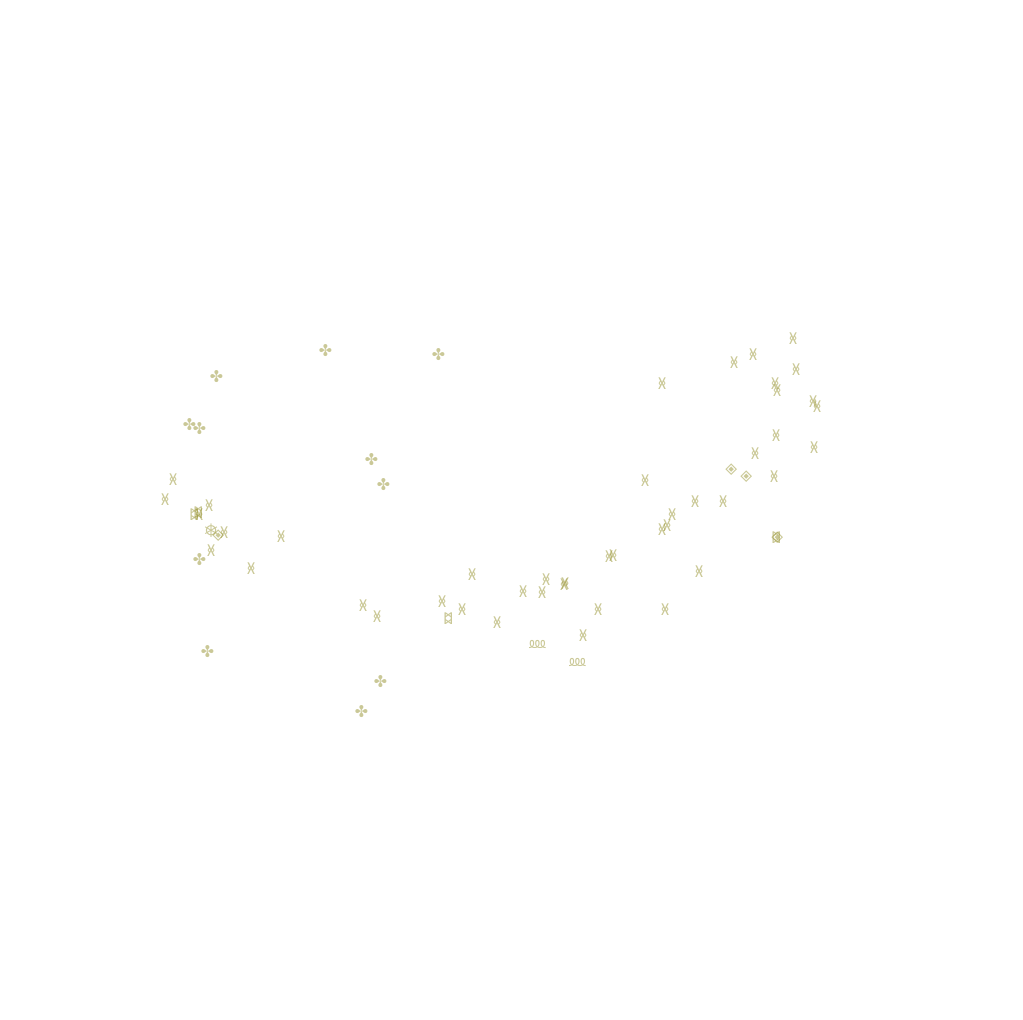

In [84]:
fig = plt.figure(figsize=figsize)
ax = plt.axes(projection=projection_method)

for index, row in messiers.iterrows(): 
    if row['code'] in [u"\u16b8", u"\u16e5", u"\u16BC", u"\u16bb"]:
        fontprop = prop_seguihis
    else: 
        fontprop = prop_seguisym
    ax.text(row['ra']*360/24, row['dec'], row['code'], transform=ccrs.Geodetic(), alpha=0.5,
          fontsize=12, color=other_color, ha='center', va='center', fontproperties=fontprop)
    
ax.set_xlim(ax.get_xlim()[::-1])
set_save_image(fig, './figures/messier_ngcs.png')

MERG NOT subset; don't know how to subset; dropped


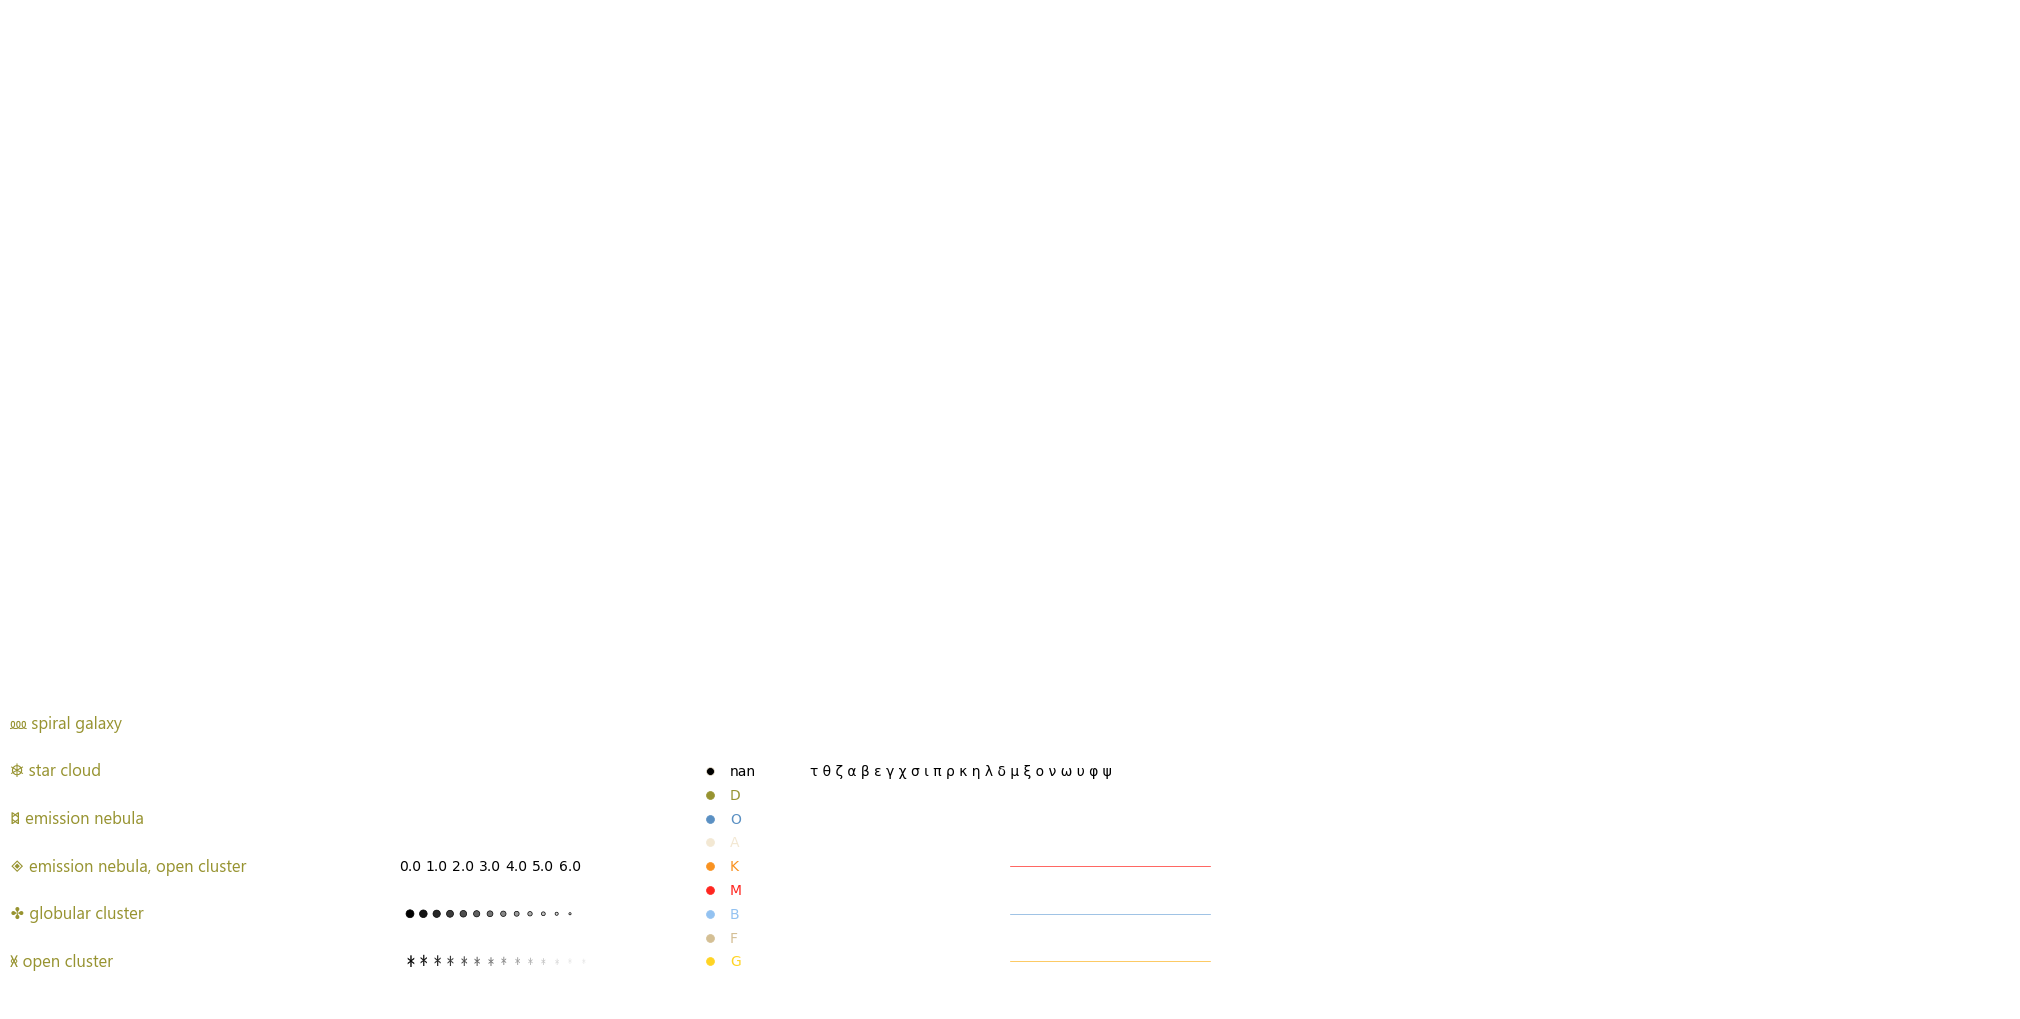

In [85]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

# Key for non-star object codes
codes = messiers.drop_duplicates(subset='type', keep='first')
codes.reset_index(inplace=True)
for index, row in codes.iterrows(): 
    if row['code'] in [u"\u16b8", u"\u16e5", u"\u16BC", u"\u16bb"]:
        fontprop = prop_seguihis
    else: 
        fontprop = prop_seguisym
    ax.text(0, index, row['code']+" "+row['type'], alpha=1, fontsize=12, 
            color=other_color, ha='left', va='center', fontproperties=fontprop)
    
# Keys for star sizes
mags = np.arange(0, 6.55, 0.5)
for index, mag in enumerate(mags): 
    # Numbers
    if index % 2 == 0:
        ax.text(2+index/15, 2, mag, ha='center', va='center')
    
    # Key for variable star sizes
    ax.text(2+index/15, 0, u"\u16BC", fontproperties=prop_seguihis, fontsize=(12-mag), 
            alpha=max(0.1, min(1,((6.5-mag)*5)/(6.5*5))), color='k', ha='center', va='center')

    # Key for normal star sizes
    ax.scatter(2+index/15, 1, s=(6.5-mag)*5, color='k', lw=0, edgecolor='none', 
               alpha=min(1, ((6.5-mag)*5)/(6.5*5)))
    ax.scatter(2+index/15, 1, alpha=1, s=(6.5-mag)*5, edgecolor='k', lw=0.5, facecolor='none')

# Key for colors
cols = stars.drop_duplicates(subset='color', keep='first')
cols.reset_index(inplace=True)
for index, row in cols.iterrows(): 
    ax.scatter(3.5, index/2, s=6.5*5, lw=0.5, 
               edgecolor=row['linecolor'], color=row['color'])
    ax.text(3.6, index/2, row['spect_desig'], ha='left', va='center', color=row['color'])

# Key to zodiac colors
ax.plot([5, 6], [0, 0], color=zodiac_color, lw=0.5)
ax.plot([5, 6], [1, 1], color=nonzodiac_color, lw=0.5)
ax.plot([5, 6], [2, 2], color=const_color, lw=0.5)

# Key for colors
cols = stars.drop_duplicates(subset='greek_letters', keep='first')
cols.reset_index(inplace=True)
letterlist = cols['greek_letters'].tolist()
letterlist = [x for x in letterlist if len(str(x)) == 1]
letterlist = " ".join(letterlist)
ax.text(4, 4, letterlist, ha='left', va='center', color=row['color'])

ax.set_xlim(0, 10)
ax.set_ylim(-1, 20)
set_save_image(fig, './figures/key.pdf')

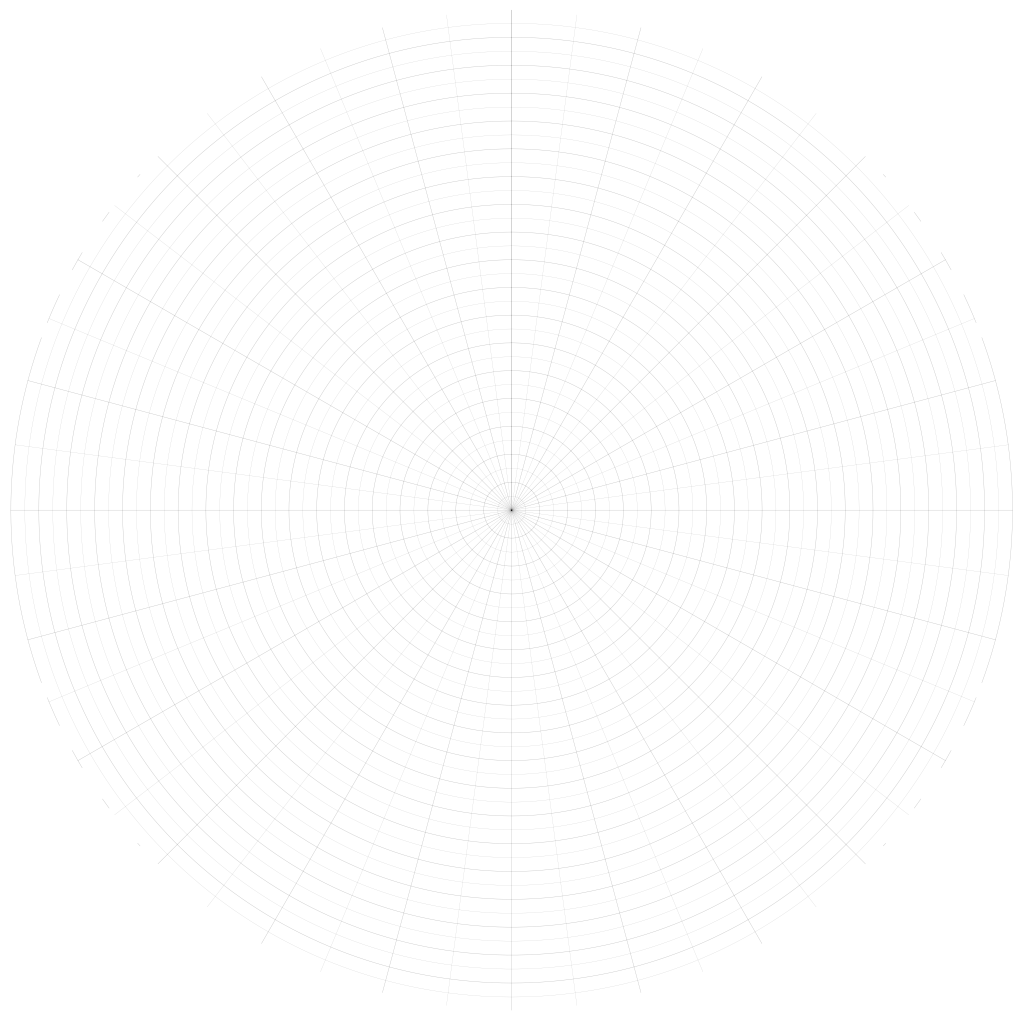

In [86]:
savename = './figures/gridlines.png'

fig = plt.figure(figsize=figsize)
ax = plt.axes(projection=projection_method)
ax.set_global()
# ax.background_patch.set_fill(False)

lon_large = np.arange(-180, 181, 1*360/24)
lon_small = np.arange(-180, 181, 0.5*360/24)
lat_large = np.arange(-90, 91, 10)
lat_small = np.arange(-90, 91, 5)
lat_delim = np.arange(-90, 90.01, 0.1)
lon_delim = np.arange(-180, 180.01, 0.1)

for lg in lat_large: 
    ax.plot(lon_delim, [lg]*len(lon_delim), transform=ccrs.PlateCarree(), 
            color='k', lw=0.25, alpha=0.25, clip_on=False)
for sm in lat_small: 
    if sm not in lat_large: 
        ax.plot(lon_delim, [sm]*len(lon_delim), transform=ccrs.PlateCarree(), 
                color='k', lw=0.125, alpha=0.25, clip_on=False)
for lg in lon_large: 
    ax.plot([lg]*len(lat_delim), lat_delim, transform=ccrs.PlateCarree(), 
            color='k', lw=0.25, alpha=0.25, clip_on=False)
for sm in lon_small: 
    if sm not in lon_large: 
        ax.plot([sm]*len(lat_delim), lat_delim, transform=ccrs.PlateCarree(), 
                color='k', lw=0.125, alpha=0.25, clip_on=False)

set_save_image(fig, savename)

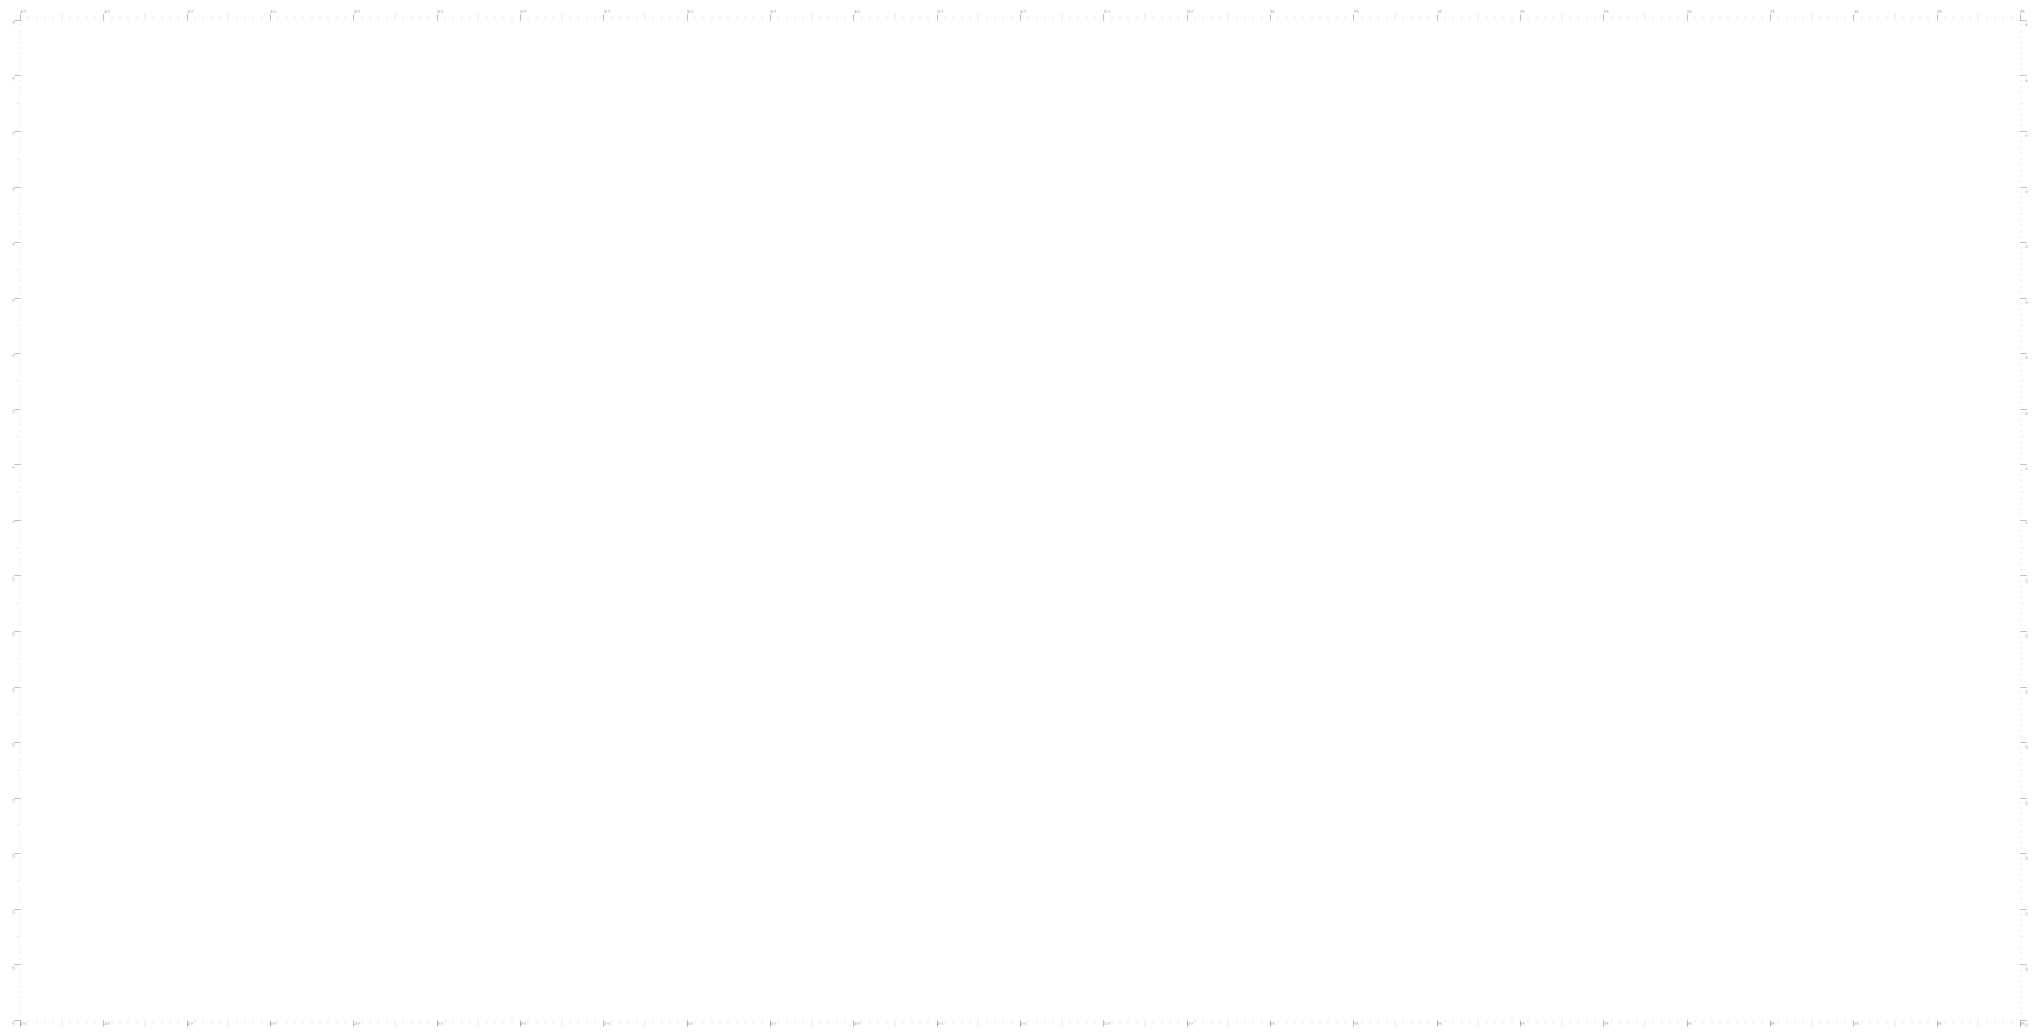

In [87]:
savename = './figures/gridlines_labels.pdf'

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)
shift = 20.242874009/20
shift_y = 360*(shift/2)-180
shift_x = 180*(shift/2)-90

lon_large = np.arange(-180, 181, 1*360/24)
lon_small = np.arange(-180, 181, 0.5*360/24)
lon_mini = np.arange(-180, 181, 0.1*360/24)
lat_large = np.arange(-90, 91, 10)
lat_small = np.arange(-90, 91, 5)
lat_mini = np.arange(-90, 91, 1)

for lg in lat_large: 
    ax.plot([-180-shift_x, -180], [lg]*2, color='k', lw=0.5, alpha=0.35, clip_on=False)
    ax.text(-180-shift_x, lg, str(lg)+"°", rotation=-90,
            color='k', alpha=0.35, ha='right', va='top', clip_on=False, fontsize=2)
    ax.plot([180+shift_x, 180], [lg]*2, color='k', lw=0.5, alpha=0.35, clip_on=False)
    ax.text(180+shift_x, lg, str(lg)+"°", rotation=90,
            color='k', alpha=0.35, ha='left', va='top', clip_on=False, fontsize=2)
for sm in lat_small: 
    if sm not in lat_large: 
        ax.plot([-180-shift_x*0.5, -180], [sm]*2, color='k', lw=0.25, alpha=0.25, clip_on=False)
        ax.plot([180+shift_x*0.5, 180], [sm]*2, color='k', lw=0.25, alpha=0.25, clip_on=False)
for m in lat_mini: 
    if (m not in lat_large) and (m not in lat_small): 
        ax.plot([-180-shift_x*0.25, -180], [m]*2, color='k', lw=0.25, alpha=0.25, clip_on=False)
        ax.plot([180+shift_x*0.25, 180], [m]*2, color='k', lw=0.25, alpha=0.25, clip_on=False)
for i, lg in enumerate(lon_large): 
    hr = int(24 - i)
    ax.plot([lg]*2, [-90-shift_y*0.5, -90], color='k', lw=0.5, alpha=0.35, clip_on=False)
    ax.text(lg, -90-shift_y*0.5, str(hr)+"HR", color='k', alpha=0.35, 
            ha='left', va='bottom', clip_on=False, fontsize=2)
    ax.plot([lg]*2, [90+shift_y*0.5, 90], color='k', lw=0.5, alpha=0.35, clip_on=False)
    ax.text(lg, 90+shift_y*0.5, str(hr)+"HR", color='k', alpha=0.35, 
            ha='left', va='bottom', clip_on=False, fontsize=2)
for sm in lon_small: 
    if sm not in lon_large: 
        ax.plot([sm]*2, [-90-shift_y*0.5, -90], color='k', lw=0.25, alpha=0.25, clip_on=False)
        ax.plot([sm]*2, [90+shift_y*0.5, 90], color='k', lw=0.25, alpha=0.25, clip_on=False)
for m in lon_mini: 
    if (m not in lon_large) and (m not in lon_small): 
        ax.plot([m]*2, [-90-shift_y*0.25, -90], color='k', lw=0.25, alpha=0.25, clip_on=False)
        ax.plot([m]*2, [90+shift_y*0.25, 90], color='k', lw=0.25, alpha=0.25, clip_on=False)

set_save_image(fig, savename)